# Project 3: Cluster Validation
#### The purpose is to apply the cluster validation technique to data extracted from a provided data set.

In [17]:
import pandas as pd
import math
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
#from main import extract_features, perform_PCA

### Extracting Datasets

In [19]:
insulin_data_file_path = 'InsulinData.csv'
cgm_data_file_path = 'CGMData.csv'

In [20]:
insulin_dataset_full = pd.read_csv(insulin_data_file_path, low_memory = False)
insulin_data = insulin_dataset_full[['Date', 'Time', 'BWZ Carb Input (grams)']]

In [21]:
insulin_data

,Date,Time,BWZ Carb Input (grams)
0,2/12/2018,13:20:53,NaN
1,2/12/2018,13:20:48,NaN
2,2/12/2018,13:18:48,NaN
3,2/12/2018,13:18:48,NaN
4,2/12/2018,13:12:33,NaN
...,...,...,...
41430,7/24/2017,19:00:01,NaN
41431,7/24/2017,18:59:44,NaN
41432,7/24/2017,18:59:44,NaN
41433,7/24/2017,18:59:44,NaN


In [22]:
cgm_data_set_full = pd.read_csv('CGMData.csv', low_memory = False)
cgm_data = cgm_data_set_full[['Date', 'Time', 'Sensor Glucose (mg/dL)']]
cgm_data.dropna(inplace = True)

In [23]:
cgm_data

,Date,Time,Sensor Glucose (mg/dL)
0,2/12/2018,13:22:27,118.0
1,2/12/2018,13:17:27,122.0
5,2/12/2018,12:57:27,124.0
6,2/12/2018,12:52:27,126.0
7,2/12/2018,12:47:27,127.0
...,...,...,...
55338,7/25/2017,12:28:54,311.0
55339,7/25/2017,12:23:54,311.0
55340,7/25/2017,12:18:54,309.0
55341,7/25/2017,12:13:54,310.0


### Combining Date and Time as DateTime object

In [24]:
insulin_data['DateTime'] = pd.to_datetime(insulin_data['Date'] + ' ' + insulin_data['Time'], format = '%m/%d/%Y %H:%M:%S')
cgm_data['DateTime'] = pd.to_datetime(cgm_data['Date'] + " " + cgm_data['Time'], format = '%m/%d/%Y %H:%M:%S')

In [25]:
insulin_data

,Date,Time,BWZ Carb Input (grams),DateTime
0,2/12/2018,13:20:53,NaN,2018-02-12 13:20:53
1,2/12/2018,13:20:48,NaN,2018-02-12 13:20:48
2,2/12/2018,13:18:48,NaN,2018-02-12 13:18:48
3,2/12/2018,13:18:48,NaN,2018-02-12 13:18:48
4,2/12/2018,13:12:33,NaN,2018-02-12 13:12:33
...,...,...,...,...
41430,7/24/2017,19:00:01,NaN,2017-07-24 19:00:01
41431,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44
41432,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44
41433,7/24/2017,18:59:44,NaN,2017-07-24 18:59:44


In [26]:
cgm_data

,Date,Time,Sensor Glucose (mg/dL),DateTime
0,2/12/2018,13:22:27,118.0,2018-02-12 13:22:27
1,2/12/2018,13:17:27,122.0,2018-02-12 13:17:27
5,2/12/2018,12:57:27,124.0,2018-02-12 12:57:27
6,2/12/2018,12:52:27,126.0,2018-02-12 12:52:27
7,2/12/2018,12:47:27,127.0,2018-02-12 12:47:27
...,...,...,...,...
55338,7/25/2017,12:28:54,311.0,2017-07-25 12:28:54
55339,7/25/2017,12:23:54,311.0,2017-07-25 12:23:54
55340,7/25/2017,12:18:54,309.0,2017-07-25 12:18:54
55341,7/25/2017,12:13:54,310.0,2017-07-25 12:13:54


In [27]:
def get_datasets(insulin_data_file_path, cgm_data_file_path, date_time_format):
    if date_time_format == '':
        date_time_format = '%m/%d/%Y %H:%M:%S'
    insulin_dataset_full = pd.read_csv(insulin_data_file_path, low_memory = False)
    insulin_data = insulin_dataset_full[['Date', 'Time', 'BWZ Carb Input (grams)']]
    cgm_data_set_full = pd.read_csv(cgm_data_file_path, low_memory = False)
    cgm_data = cgm_data_set_full[['Date', 'Time', 'Sensor Glucose (mg/dL)']]
    cgm_data.dropna(inplace = True)
    insulin_data['DateTime'] = pd.to_datetime(insulin_data['Date'] + ' ' + insulin_data['Time'], format = date_time_format)
    cgm_data['DateTime'] = pd.to_datetime(cgm_data['Date'] + " " + cgm_data['Time'], format = date_time_format)
    return insulin_data, cgm_data

In [28]:
insulin_dataset, cgm_dataset = get_datasets(insulin_data_file_path, cgm_data_file_path, '%m/%d/%Y %H:%M:%S')

## Meal Data Extraction along with Carb Intake values

In [29]:
#insulin_data_carb = insulin_data[insulin_data['BWZ Carb Input (grams)'].notna() & insulin_data['BWZ Carb Input (grams)'] != 0]

In [30]:
#insulin_data_carb.rename({'DateTime' : 'MealStartDateTime'}, axis = 1, inplace = True)

In [31]:
#insulin_data_carb.sort_values(by = 'MealStartDateTime', inplace = True)

In [32]:
#insulin_data_carb

In [33]:
#insulin_data_carb = insulin_data_carb[['MealStartDateTime', 'BWZ Carb Input (grams)']]

In [34]:
#meal_start_times_with_carb = [tuple(x) for x in insulin_data_carb.to_numpy()]

In [35]:
#meal_start_times_with_carb

In [36]:
def get_meal_start_times_with_carb(insulin_dataset):
    insulin_data_carb = insulin_dataset[insulin_dataset['BWZ Carb Input (grams)'].notna() & insulin_dataset['BWZ Carb Input (grams)'] != 0]
    insulin_data_carb.rename({'DateTime' : 'MealStartDateTime'}, axis = 1, inplace = True)
    insulin_data_carb = insulin_data_carb[['MealStartDateTime', 'BWZ Carb Input (grams)']]
    insulin_data_carb.sort_values(by = 'MealStartDateTime', inplace = True)
    
    meal_start_times_with_carb = [tuple(x) for x in insulin_data_carb.to_numpy()]
    
    return meal_start_times_with_carb

In [37]:
def get_valid_meal_start_times_with_carb(meal_start_times_with_carb):
    valid_meal_start_times_with_carb = []
    for i in range(len(meal_start_times_with_carb)):
        timestamp, carb = meal_start_times_with_carb[i]
        if i > 0:
            previous_timestamp = meal_start_times_with_carb[i-1][0]
            if previous_timestamp > timestamp - timedelta(hours = 0.5):
                continue

        if i < len(meal_start_times_with_carb) - 1:
            next_timestamp = meal_start_times_with_carb[i+1][0]
            if next_timestamp < timestamp + timedelta(hours = 2):
                continue

        valid_meal_start_times_with_carb.append((timestamp, carb))
    return valid_meal_start_times_with_carb

In [38]:
def extract_meal_and_carb_data(cgm_dataset, valid_meal_start_times_with_carb):
    meal_data = []
    carb_data = []
    for meal_time, carb in valid_meal_start_times_with_carb:
        start_time = meal_time - timedelta(minutes = 30)
        end_time = meal_time + timedelta(hours = 2)
        filtered_data = cgm_dataset[(cgm_dataset['DateTime'] >= start_time) & (cgm_dataset['DateTime'] <= end_time)]
        if len(filtered_data) > 0:
            meal_data.append(list(filtered_data['Sensor Glucose (mg/dL)'].values))
            carb_data.append(carb)
    return meal_data, carb_data

In [39]:
meal_start_times_with_carb = get_meal_start_times_with_carb(insulin_data)
valid_meal_start_times_with_carb = get_valid_meal_start_times_with_carb(meal_start_times_with_carb)

In [40]:
print(len(meal_start_times_with_carb))
print(len(valid_meal_start_times_with_carb))

747
561


In [41]:
meal_data, carb_data = extract_meal_and_carb_data(cgm_data, valid_meal_start_times_with_carb)

In [42]:
print(len(meal_data), len(carb_data))

541 541


## Feature Extraction

In [43]:
def normalize(df):
    return (df - df.min())/((df.max() - df.min()) * 1.0)

In [44]:
def extract_features_and_normalize(meal_data):
    F_meal_data_df = extract_features(meal_data)
    F_meal_data_df = normalize(F_meal_data_df)
    return F_meal_data_df

In [45]:
F_meal_data_df = extract_features_and_normalize(meal_data)


In [46]:
F_meal_data_df

,CGM_Max_Min_Diff,slope_delta_1,slope_delta_2,slope_delta_3,CGM_Max_Min_Time_Diff,fft_2,fft_3,fft_4
0,0.451713,0.103846,0.088435,0.166667,0.034483,0.892857,0.071429,0.821429
1,0.261682,0.053846,0.081633,0.166667,0.655172,1.000000,0.000000,0.928571
2,0.286604,0.107692,0.142857,0.243590,0.327586,0.035714,0.964286,0.892857
3,0.149533,0.042308,0.068027,0.102564,0.327586,1.000000,0.000000,0.071429
4,0.283489,0.065385,0.095238,0.179487,0.310345,0.964286,0.035714,0.750000
...,...,...,...,...,...,...,...,...
536,0.137072,0.176923,0.285714,0.269231,0.775862,0.000000,1.000000,0.035714
537,0.127726,0.111538,0.095238,0.153846,0.568966,0.071429,0.142857,0.107143
538,0.314642,0.173077,0.156463,0.307692,0.086207,0.964286,0.035714,0.107143
539,0.274143,0.084615,0.136054,0.243590,0.327586,0.892857,0.071429,0.035714


## Extracting Ground Truth: 
#### Derive the max and min value of meal intake amount from the Y column of the Insulin data. Discretize the meal amount in bins of size 20. Consider each row in the meal data matrix. Put them in the respective bins according to their meal amount label. In total you should have n = (max-min)/20 bins.


In [47]:
def dropna_and_get_corresponding_carb_data(F_meal_data_df, carb_data):
    F_meal_data_df['Carb Input'] = carb_data
    F_meal_data_df.dropna(inplace = True)
    carb_data = F_meal_data_df['Carb Input']
    F_meal_data_df.drop(columns = ['Carb Input'], axis = 1, inplace = True)
    return F_meal_data_df, carb_data

In [48]:
F_meal_data_df, carb_data = dropna_and_get_corresponding_carb_data(F_meal_data_df, carb_data)

In [49]:
len(F_meal_data_df), len(carb_data)

(528, 528)

In [50]:
def find_bin(val, min_val, bin_size):
    return int((val-min_val)/(bin_size))

In [51]:
def extract_ground_truth(carb_data, bin_size = 20):
    ground_truth = []
    min_carb = min(carb_data)
    max_carb = max(carb_data)
    for carb in carb_data:
        ground_truth.append(find_bin(carb, min_carb, bin_size))
    ground_truth_bin_count = math.ceil((max_carb - min_carb) / bin_size)
    return ground_truth, ground_truth_bin_count

In [52]:
ground_truth, ground_truth_bin_count = extract_ground_truth(carb_data)

In [53]:
len(ground_truth), ground_truth_bin_count

(528, 7)

In [54]:
#(F_meal_data_df['Ground Truth'] == 0).value_counts()[True]


## Clustering

In [55]:
X = F_meal_data_df.to_numpy()
N = ground_truth_bin_count

## K-means Clustering

In [56]:
kmeans = KMeans(n_clusters = N, random_state=2).fit(X)
kmeans_labels = kmeans.labels_
kmeans_cluster_centers = kmeans.cluster_centers_

In [57]:
np.unique(kmeans_labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 41, 130,  83,  45,  73,  66,  90], dtype=int64))

In [58]:
#SSE
kmeans_sse = 0
for i in range(len(X)):
    data = X[i]
    cluster_index = kmeans_labels[i]
    centroid = kmeans_cluster_centers[cluster_index]
    dist = distance.euclidean(data, centroid)
    kmeans_sse += math.pow(dist, 2)
print(kmeans_sse)

70.35433016569482


In [59]:
#Forming ground truth bin matrix for finding entropy

"""
ground_truth_bin_matrix = np.zeros((N, N)) #rows represent clusters; columns represent ground truth bins

for i in range(len(X)):
    data = X[i]
    cluster_index = kmeans_labels[i]
    bin_index = ground_truth[i]
    ground_truth_bin_matrix[cluster_index][bin_index] += 1
print(ground_truth_bin_matrix)
"""


def form_ground_truth_bin_matrix(X, cluster_labels, ground_truth):
    numClusters = len(np.unique(cluster_labels))
    numBins = len(np.unique(ground_truth)) #no. of ground truth values (or bins)
    ground_truth_bin_matrix = np.zeros((numClusters, numBins)) #rows represent clusters; columns represent ground truth bins
    
    for i in range(len(X)):
        data = X[i]
        cluster_index = cluster_labels[i]
        bin_index = ground_truth[i]
        ground_truth_bin_matrix[cluster_index][bin_index] += 1
    return ground_truth_bin_matrix

In [60]:
#Finding Entropy and Purity
"""
total_entropy = 0
total_purity = 0

for i in range(N):
    Ci_count = sum(ground_truth_bin_matrix[i]) #number of elements in cluster i
    
    #normalizing rows
    for j in range(N):
        ground_truth_bin_matrix[i][j] /= Ci_count
    
    Ci_entropy = entropy(ground_truth_bin_matrix[i]) #entropy of cluster i
    Ci_purity = max(ground_truth_bin_matrix[i])
    print(Ci_purity)
    total_entropy += Ci_count * Ci_entropy
    total_purity += Ci_count * Ci_purity
    
total_entropy /= len(X)
total_purity /= len(X)
kmeans_entropy = total_entropy
kmeans_purity = total_purity
"""


def compute_entropy_and_purity(ground_truth_bin_matrix, X):
    numClusters = len(ground_truth_bin_matrix)
    numBins = len(ground_truth_bin_matrix[0])
    
    total_entropy = 0
    total_purity = 0
    
    for i in range(numClusters):
        Ci_count = sum(ground_truth_bin_matrix[i]) #number of elements in cluster i
        
        #normalizing each row
        for j in range(numBins):
            ground_truth_bin_matrix[i][j] /= Ci_count
        
        Ci_entropy = entropy(ground_truth_bin_matrix[i]) #entropy of cluster i
        Ci_purity = max(ground_truth_bin_matrix[i])
        total_entropy += Ci_count * Ci_entropy
        total_purity += Ci_count * Ci_purity
        
    total_entropy /= len(X)
    total_purity /= len(X)
    
    return total_entropy, total_purity

In [61]:
def get_entropy_and_purity(X, cluster_labels, ground_truth):
    ground_truth_bin_matrix = form_ground_truth_bin_matrix(X, cluster_labels, ground_truth)
    entropy, purity = compute_entropy_and_purity(ground_truth_bin_matrix, X)
    return entropy, purity

In [62]:
kmeans_entropy, kmeans_purity = get_entropy_and_purity(X, kmeans_labels, ground_truth)

In [63]:
kmeans_sse, kmeans_entropy, kmeans_purity

(70.35433016569482, 1.4956889424137325, 0.3390151515151515)

## DBSCAN Clustering

## Finding epsilon and min points parameters for DBSCAN

In [64]:
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(distance.euclidean(X[i], X[j]))
        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])
    return kn_distance

In [65]:
k_dist = calculate_kn_distance(X, 14)

In [66]:
k_dist.sort()

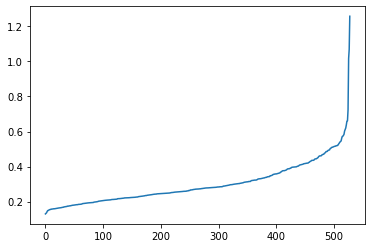

In [67]:
plt.plot(k_dist)

0.44139228286884397


<Figure size 360x360 with 0 Axes>

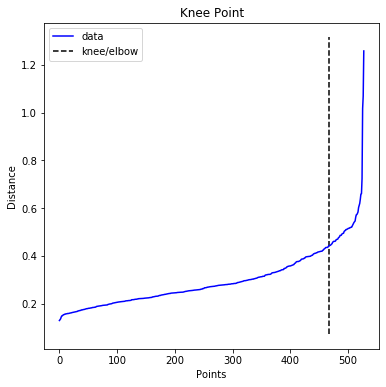

In [68]:
from kneed import KneeLocator
i = np.arange(len(k_dist))
knee = KneeLocator(i, k_dist, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(k_dist[knee.knee])

In [69]:
"""
2, 0.5-0.6  (2, 0.47)
3, 0.575 (3, 0.449)
4, 0.6
(15, 0.52)
(11, 0.4) - main.py
"""

'\n2, 0.5-0.6  (2, 0.47)\n3, 0.575 (3, 0.449)\n4, 0.6\n(15, 0.52)\n(11, 0.4) - main.py\n'

### Performing DBSCAN

In [70]:
#dbscan = DBSCAN(eps=0.65,min_samples=22).fit(X)
dbscan = DBSCAN(eps=0.4,min_samples=14).fit(X)
dbscan_labels = dbscan.labels_

In [71]:
np.unique(dbscan_labels, return_counts = True)

(array([-1,  0], dtype=int64), array([ 21, 507], dtype=int64))

In [72]:
np.unique(kmeans_labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 41, 130,  83,  45,  73,  66,  90], dtype=int64))

In [73]:
clusters = {}
for i in range(len(X)):
    data = X[i]
    cluster_index = dbscan_labels[i]
    if cluster_index not in clusters:
        clusters[cluster_index] = []
    clusters[cluster_index].append(data)

In [74]:
#Finding cluster mean

clusters = {}
for i in range(len(X)):
    data = X[i]
    cluster_index = dbscan_labels[i]
    if cluster_index not in clusters:
        clusters[cluster_index] = []
    clusters[cluster_index].append(data)

cluster_means = {}
for key in clusters:
    total = sum(clusters[key]) 
    count = len(clusters[key])
    cluster_means[key] = total/count


In [75]:
#DBSCAN SSE

dbscan_sse = 0
for i in range(len(X)):
    data = X[i]
    cluster_label = dbscan_labels[i]
    cluster_mean = cluster_means[cluster_label]
    dist = distance.euclidean(data, cluster_mean)
    dbscan_sse += math.pow(dist, 2)
print(dbscan_sse)

314.8542859171958


In [76]:
dbscan_entropy, dbscan_purity = get_entropy_and_purity(X, dbscan_labels, ground_truth)
dbscan_entropy, dbscan_purity

(1.539936458697275, 0.29924242424242425)

## DBSCAN + Bisecting K-means

In [77]:
X_df = pd.DataFrame(X)
X_df['Ground Truth Bin'] = ground_truth
X_with_ground_truth = X_df.to_numpy()

In [78]:
def retrieve_clusters(data_array, labels):
    clusters = []
    df = pd.DataFrame(data_array)
    df['label'] = labels
    unique_labels = df['label'].unique()
    for label in unique_labels:
        clusters.append(df[df['label'] == label].loc[:, df.columns != 'label'].to_numpy())
    return clusters

In [79]:
def compute_sse_for_clusters(clusters_list):
    sse_list = []
    for cluster in clusters_list:
        cluster_mean = sum(cluster)/len(cluster)
        sse = 0
        for point in cluster:
            sse += math.pow(distance.euclidean(point, cluster_mean), 2)
        sse_list.append(sse)
    return sse_list

In [80]:
def partition_using_bisecting_kmeans(data_array):
    clustering = KMeans(n_clusters = 2, random_state=0).fit(data_array)
    clusters_list = retrieve_clusters(data_array, clustering.labels_)
    return clusters_list

In [81]:
dbscan = DBSCAN(eps=0.8,min_samples=14).fit(X)
dbscan_labels = dbscan.labels_

In [82]:
np.unique(dbscan_labels, return_counts = True)

(array([-1,  0], dtype=int64), array([  1, 527], dtype=int64))

In [83]:
clusters_list_with_ground_truth = retrieve_clusters(X_with_ground_truth, dbscan_labels)
#clusters_list_with_ground_truth = [X_with_ground_truth]
clusters_list_without_ground_truth = [cluster[:, :-1] for cluster in clusters_list_with_ground_truth]

sse_list = compute_sse_for_clusters(clusters_list_without_ground_truth)
while len(clusters_list_with_ground_truth) < N:
    max_sse_index = np.argsort(sse_list)[-1]
    new_clusters = partition_using_bisecting_kmeans(clusters_list_with_ground_truth[max_sse_index])
    clusters_list_with_ground_truth = clusters_list_with_ground_truth[:max_sse_index] + clusters_list_with_ground_truth[max_sse_index + 1 :] + new_clusters
    clusters_list_without_ground_truth = [cluster[:, :-1] for cluster in clusters_list_with_ground_truth]
    sse_list = compute_sse_for_clusters(clusters_list_without_ground_truth)
dbscan_sse = sum(sse_list)
print(dbscan_sse)

183.77932945595606


In [84]:
[len(cluster) for cluster in clusters_list_with_ground_truth]

[1, 158, 141, 52, 76, 39, 61]

In [85]:
data_array = []
cluster_labels = []
data_ground_truth_bins = []
for i in range(len(clusters_list_with_ground_truth)):
    cluster_data_with_ground_truth = clusters_list_with_ground_truth[i]
    for data in cluster_data_with_ground_truth:
        data_array.append(data[:-1])
        data_ground_truth_bins.append(int(data[-1]))
        cluster_labels.append(i)
dbscan_entropy, dbscan_purity = get_entropy_and_purity(data_array, cluster_labels, data_ground_truth_bins)
print(dbscan_sse, dbscan_entropy, dbscan_purity)

183.77932945595606 0.431558720042098 0.7178030303030303


## Storing Result

In [86]:
result_df = pd.DataFrame([[kmeans_sse, dbscan_sse, kmeans_entropy, dbscan_entropy, kmeans_purity, dbscan_purity]])

In [87]:
result_df

,0,1,2,3,4,5
0,70.35433,183.779329,1.495689,0.431559,0.339015,0.717803


In [88]:
result_df.to_csv('Results.csv', index = False, header = False)

In [89]:
kmeans purity - 0.348485, 0.361151 - Test case 17 passed

kmeans entropy - 1.489256 - Test case 1 passed

Test case 22 - dbscan purity - 0.29
Test case 27 - dbscan purity - 0.570076
Test case 20 - dbscan purity - 0.664773
Test case 19 - dbscan purity - 0.842475, 0.844604
Test case 21 - dbscan purity - 0.473485

dbscan entropy - 1.540834, 0.234801 - Test case 7 passed 
Test case 12 - dbscan entropy - 0.139786

SyntaxError: invalid syntax (<ipython-input-89-d6819bbd58d2>, line 1)